In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from tqdm import tqdm

# 데이터 불러오기
train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

X = train.drop(columns=['ID', '성공확률'])
y = train['성공확률']
X_test = test.drop(columns=['ID'])

def build_model(input_dim, units, dropout_rates, lr, n_layers):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for i in range(n_layers):
        model.add(Dense(units[i], activation='relu'))
        model.add(Dropout(dropout_rates[i]))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model

def objective(trial):
    # Optuna 하이퍼파라미터 샘플링
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    epochs = trial.suggest_int('epochs', 100, 500)
    dropout_rates = [trial.suggest_float(f'dropout{i}', 0.0, 0.7) for i in range(1, 5)]
    units = [trial.suggest_int(f'units{i}', 16, 512) for i in range(1, 5)]
    n_layers = trial.suggest_int('n_layers', 3, 4)

    # 10-Fold 교차검증
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_mae_list = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = build_model(X.shape[1], units, dropout_rates, lr, n_layers)

        early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                  validation_data=(X_val, y_val), verbose=0, callbacks=[early_stop])

        val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
        fold_mae_list.append(val_loss)

    return np.mean(fold_mae_list)

# Optuna 최적화
n_trials = 100
study = optuna.create_study(direction='minimize')

with tqdm(total=n_trials) as pbar:
    def tqdm_callback(study, trial):
        pbar.update(1)
    study.optimize(objective, n_trials=n_trials, callbacks=[tqdm_callback])

# 결과 출력
print("Best trial:")
trial = study.best_trial
print(f"  Value (MAE): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
early_stop = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

model.fit(X, y, epochs=best_params['epochs'], batch_size=best_params['batch_size'],
          verbose=1, callbacks=[early_stop])

y_test_pred = model.predict(X_test_scaled).flatten()

submission = pd.DataFrame({
    'ID': test['ID'],
    '성공확률': y_test_pred.clip(0, 1)
})

submission.to_csv('../../data/output/submission_long_tuning.csv', index=False)

[I 2025-05-25 00:53:16,758] A new study created in memory with name: no-name-d1fa7e6f-ebbe-4d32-aaab-0dafe8f78685
 66%|██████▌   | 66/100 [2:25:24<1:17:13, 136.26s/it]

In [ ]:
submission

train['성공확률'].value_counts()

# 프로젝트 계획 요약

## 1. 데이터 이해 및 전처리
- 성공확률이 0.1 단위로 구분된 이산형 값임을 확인
- 범주형 변수 원핫 인코딩, 수치형 변수 정규화 적용
- 성공확률을 클래스(분류 레이블)로 변환 (예: 0.1 → 클래스 1, 0.2 → 클래스 2 ...)

## 2. 문제 정의
- 성공확률 예측 → 회귀보다는 분류 문제로 전환하여 접근
- 다중 클래스 분류 문제로 모델 학습

## 3. 모델링
- 신경망 모델 설계 (MLP 기반 다중 은닉층)
- 하이퍼파라미터 튜닝 (Optuna 활용)
  - 은닉층 수, 유닛 수, 드롭아웃 비율, 학습률, 배치사이즈, 에포크 범위 등 폭넓게 설정
- 조기 종료(EarlyStopping) 적용

## 4. 학습 및 검증
- 교차검증 또는 Hold-out 검증으로 과적합 방지 및 일반화 평가
- MAE 외 분류 정확도 등 다양한 평가 지표 활용

## 5. 예측 및 제출
- 테스트 데이터에 대해 클래스 예측 수행
- 예측 클래스 → 성공확률 값으로 매핑하여 결과 생성
- 제출 파일 생성 및 평가

## 6. 향후 개선 및 확장
- 분류+회귀 혼합 모델 고려
- 샘플 가중치, 손실 함수 커스터마이징 등 불균형 및 비대칭 분포 대응 전략 적용
- 다양한 신경망 아키텍처 실험 (CNN, Transformer 등)

# 기본 MLP 모델 구성 (은닉층 2개)
model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # 출력층 (회귀)

In [23]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 불러오기
train = pd.read_csv("../../data/processed/feature_importance_test.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1755 non-null   object 
 1   직원 수            1755 non-null   float64
 2   직원당매출           1755 non-null   float64
 3   가치대비매출          1755 non-null   float64
 4   SNS 팔로워 수(백만명)  1755 non-null   float64
 5   연매출(억원)         1755 non-null   float64
 6   고객당매출           1755 non-null   float64
 7   총 투자금(억원)       1755 non-null   float64
 8   투자수익비           1755 non-null   float64
 9   투자단계            1755 non-null   float64
dtypes: float64(9), object(1)
memory usage: 137.2+ KB


In [25]:
train['성공확률'].value_counts()

KeyError: '성공확률'

In [ ]:
test.info()

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 준비
X = train.drop(columns=['ID', '성공확률'])
y = train['성공확률']
X_test = test.drop(columns=['ID'])

# 하이퍼파라미터
learning_rate = 0.0001112408115243152
batch_size = 16
epochs = 471
dropout1 = 0.06114446479113117
dropout2 = 0.00037525412817682874
dropout3 = 0.6447411638190662
dropout4 = 0.40273771947175707
units1 = 462
units2 = 466
units3 = 230
units4 = 248
n_layers = 3

# 예측 결과 저장용
test_preds = np.zeros(len(X_test))
val_mae_list = []

# 10-Fold 교차 검증 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'\n🔁 Fold {fold+1}')
    
    # 데이터 분리
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 모델 구성
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    model.add(Dense(units1, activation='relu'))
    model.add(Dropout(dropout1))
    
    if n_layers >= 2:
        model.add(Dense(units2, activation='relu'))
        model.add(Dropout(dropout2))
    
    if n_layers >= 3:
        model.add(Dense(units3, activation='relu'))
        model.add(Dropout(dropout3))
    
    if n_layers >= 4:
        model.add(Dense(units4, activation='relu'))
        model.add(Dropout(dropout4))
    
    model.add(Dense(1))  # 출력층

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error']
    )
    
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
    
    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    
    # 검증 성능 저장
    val_pred = model.predict(X_val).flatten()
    val_mae = mean_absolute_error(y_val, val_pred)
    val_mae_list.append(val_mae)
    print(f'📉 Fold {fold+1} MAE: {val_mae:.4f}')
    
    # 테스트 예측 (각 fold 결과 평균)
    test_preds += model.predict(X_test).flatten() / kf.n_splits

# 전체 검증 결과 출력
print(f'\n✅ 평균 검증 MAE: {np.mean(val_mae_list):.4f} ± {np.std(val_mae_list):.4f}')

# 제출 파일 생성
submission = pd.DataFrame({
    'ID': test['ID'],
    '성공확률': test_preds.clip(0, 1)
})

submission.to_csv('../../data/output/submission_kfold_mlp_tuned.csv', index=False)


🔁 Fold 1
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
📉 Fold 1 MAE: 0.3112
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step

🔁 Fold 2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
📉 Fold 2 MAE: 0.2944
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step

🔁 Fold 3
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
📉 Fold 3 MAE: 0.2916
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step

🔁 Fold 4
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
📉 Fold 4 MAE: 0.2793
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step

🔁 Fold 5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
📉 Fold 5 MAE: 0.2506
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step

🔁 Fold 6
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
📉 Fold 6 MAE: 0.2952
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step

🔁 Fold 7
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
📉 Fold 7 MAE: 0.2897
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step

🔁 Fold 8
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
📉 Fold 8 MAE: 0.2693
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step

🔁 Fold 9
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
📉 Fold 9 MAE: 0.2740
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 576

In [14]:
submission.head()

,ID,성공확률
0,TEST_0000,0.437475
1,TEST_0001,0.552629
2,TEST_0002,0.433878
3,TEST_0003,0.366867
4,TEST_0004,0.658146


# 랜덤 포레스트

In [1]:
import pandas as pd
# 데이터 불러오기
train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              3800 non-null   object 
 1   직원 수            3800 non-null   float64
 2   직원당매출           3800 non-null   float64
 3   가치대비매출          3800 non-null   float64
 4   SNS 팔로워 수(백만명)  3800 non-null   float64
 5   연매출(억원)         3800 non-null   float64
 6   고객당매출           3800 non-null   float64
 7   총 투자금(억원)       3800 non-null   float64
 8   투자수익비           3800 non-null   float64
 9   투자단계            3800 non-null   float64
 10  성공확률            3800 non-null   float64
dtypes: float64(10), object(1)
memory usage: 326.7+ KB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1755 non-null   object 
 1   직원 수            1755 non-null   float64
 2   직원당매출           1755 non-null   float64
 3   가치대비매출          1755 non-null   float64
 4   SNS 팔로워 수(백만명)  1755 non-null   float64
 5   연매출(억원)         1755 non-null   float64
 6   고객당매출           1755 non-null   float64
 7   총 투자금(억원)       1755 non-null   float64
 8   투자수익비           1755 non-null   float64
 9   투자단계            1755 non-null   float64
dtypes: float64(9), object(1)
memory usage: 137.2+ KB


In [30]:
train.describe()

,직원 수,직원당매출,가치대비매출,SNS 팔로워 수(백만명),연매출(억원),고객당매출,총 투자금(억원),투자수익비,투자단계,성공확률
count,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.00000
mean,0.493533,0.005068,0.004613,0.516223,0.434193,0.023337,0.471231,0.006602,0.502961,0.53750
std,0.284328,0.025564,0.031402,0.283111,0.255047,0.060704,0.266475,0.035699,0.358600,0.24972
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.10000
25%,0.250100,0.000778,0.000615,0.270000,0.209504,0.005859,0.236555,0.000972,0.250000,0.37500
50%,0.493956,0.001553,0.001169,0.574000,0.433693,0.011672,0.483894,0.001911,0.500000,0.55000
75%,0.735079,0.003120,0.002816,0.800000,0.651452,0.019920,0.694799,0.003596,0.750000,0.72500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.90000


In [31]:
test.describe()

,직원 수,직원당매출,가치대비매출,SNS 팔로워 수(백만명),연매출(억원),고객당매출,총 투자금(억원),투자수익비,투자단계
count,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000
mean,0.497039,0.005473,0.008120,0.507005,0.462029,0.018801,0.457245,0.007956,0.505698
std,0.281365,0.038084,0.049571,0.278924,0.270300,0.040763,0.263459,0.034990,0.355618
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.262335,0.000628,0.000814,0.253000,0.228701,0.005582,0.228888,0.001386,0.250000
50%,0.497039,0.001297,0.001491,0.512000,0.459616,0.010981,0.466093,0.002613,0.500000
75%,0.737966,0.002645,0.003608,0.800000,0.693601,0.018896,0.673833,0.005184,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# 데이터 준비
X = train.drop(columns=['ID', '성공확률'])
y = train['성공확률']
X_test = test.drop(columns=['ID'])

# Base 모델들
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Meta 모델
meta_model = Ridge(alpha=1.0)

# Stacking 모델 구성
stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# 교차검증 및 예측
kf = KFold(n_splits=15, shuffle=True, random_state=42)
val_mae_list = []
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n🌲 Fold {fold+1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    stacked_model.fit(X_train, y_train)
    val_pred = stacked_model.predict(X_val)
    
    mae = mean_absolute_error(y_val, val_pred)
    val_mae_list.append(mae)
    print(f"📉 Fold {fold+1} MAE: {mae:.4f}")
    
    test_preds += stacked_model.predict(X_test) / kf.n_splits

# 최종 MAE 출력
print(f"\n✅ 평균 검증 MAE: {np.mean(val_mae_list):.4f} ± {np.std(val_mae_list):.4f}")

# 결과 저장
submission = pd.DataFrame({
    'ID': test['ID'],
    '성공확률': test_preds.clip(0, 1)
})
submission.to_csv('../../data/output/submission_stacking_gb_rf.csv', index=False)


🌲 Fold 1
📉 Fold 1 MAE: 0.2413

🌲 Fold 2
📉 Fold 2 MAE: 0.2360

🌲 Fold 3
📉 Fold 3 MAE: 0.2353

🌲 Fold 4
📉 Fold 4 MAE: 0.2253

🌲 Fold 5
📉 Fold 5 MAE: 0.2323

🌲 Fold 6
📉 Fold 6 MAE: 0.2210

🌲 Fold 7
📉 Fold 7 MAE: 0.2156

🌲 Fold 8
📉 Fold 8 MAE: 0.2269

🌲 Fold 9
📉 Fold 9 MAE: 0.2185

🌲 Fold 10
📉 Fold 10 MAE: 0.2451

🌲 Fold 11
📉 Fold 11 MAE: 0.2346

🌲 Fold 12
📉 Fold 12 MAE: 0.2333

🌲 Fold 13
📉 Fold 13 MAE: 0.2335

🌲 Fold 14
📉 Fold 14 MAE: 0.2338

🌲 Fold 15
📉 Fold 15 MAE: 0.2252

✅ 평균 검증 MAE: 0.2305 ± 0.0080


# LightGBM

In [4]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# 데이터 준비
X = train.drop(columns=['ID', '성공확률'])
y = train['성공확률']
X_test = test.drop(columns=['ID'])

# 하이퍼파라미터 설정
params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 15,
    'num_leaves': 64,
    'min_child_samples': 10,
    'min_gain_to_split': 0.0,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'random_state': 42,
    'n_jobs': -1
}

# 예측 결과 저장용
test_preds = np.zeros(len(X_test))
val_mae_list = []
fold_results = []  # 🔥 Fold별 성능 저장용

# 10-Fold 교차 검증
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'\n🌿 LGBM Fold {fold+1}')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_pred)
    
    val_mae_list.append(val_mae)
    fold_results.append({'Fold': fold+1, 'MAE': val_mae})  # 🔥 성능 기록
    
    print(f'📉 Fold {fold+1} MAE: {val_mae:.4f}')
    
    test_preds += model.predict(X_test) / kf.n_splits

# 평균 및 표준편차 출력
mean_mae = np.mean(val_mae_list)
std_mae = np.std(val_mae_list)
print(f'\n✅ 평균 검증 MAE: {mean_mae:.4f} ± {std_mae:.4f}')

# Fold별 MAE를 데이터프레임으로 정리
fold_results_df = pd.DataFrame(fold_results)
print("\n📋 Fold별 MAE:")
print(fold_results_df)

# 필요 시 저장
# fold_results_df.to_csv('../../data/output/fold_mae_lgbm.csv', index=False)

# 제출 파일 저장
submission = pd.DataFrame({
    'ID': test['ID'],
    '성공확률': test_preds.clip(0, 1)
})
submission.to_csv('../../data/output/submission_kfold_lgbm.csv', index=False)


🌿 LGBM Fold 1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

# XGBoost

In [11]:
import pandas as pd
# 데이터 불러오기
train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              3800 non-null   object 
 1   총 투자금(억원)       3800 non-null   float64
 2   가치대비매출          3800 non-null   float64
 3   직원 수            3800 non-null   float64
 4   총투자금당직원수        3800 non-null   float64
 5   직원당매출           3800 non-null   float64
 6   SNS 팔로워 수(백만명)  3800 non-null   float64
 7   고객당매출           3800 non-null   float64
 8   투자수익비           3800 non-null   float64
 9   연매출(억원)         3800 non-null   float64
 10  고객수(백만명)        3800 non-null   float64
 11  설립연도            3800 non-null   float64
 12  기업나이            3800 non-null   float64
 13  투자단계            3800 non-null   float64
 14  기업가치(백억원)       3800 non-null   float64
 15  성공확률            3800 non-null   float64
dtypes: float64(15), object(1)
memory usage: 475.1+ KB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1755 non-null   object 
 1   총 투자금(억원)       1755 non-null   int64  
 2   가치대비매출          1755 non-null   float64
 3   직원 수            1755 non-null   float64
 4   총투자금당직원수        1755 non-null   float64
 5   직원당매출           1755 non-null   float64
 6   SNS 팔로워 수(백만명)  1755 non-null   float64
 7   고객당매출           1755 non-null   float64
 8   투자수익비           1755 non-null   float64
 9   연매출(억원)         1755 non-null   int64  
 10  고객수(백만명)        1755 non-null   float64
 11  설립연도            1755 non-null   int64  
 12  기업나이            1755 non-null   int64  
 13  투자단계            1755 non-null   int64  
 14  기업가치(백억원)       1755 non-null   float64
dtypes: float64(9), int64(5), object(1)
memory usage: 205.8+ KB


In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# 데이터 준비
X = train.drop(columns=['ID', '성공확률'])
y = train['성공확률']
X_test = test.drop(columns=['ID'])

# 하이퍼파라미터
params = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'gamma': 0,
    'random_state': 42,
    'n_jobs': -1
}

test_preds = np.zeros(len(X_test))
val_mae_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'\n🔥 XGBoost Fold {fold+1}')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=100)
    
    val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_pred)
    val_mae_list.append(val_mae)
    print(f'📉 Fold {fold+1} MAE: {val_mae:.4f}')
    
    test_preds += model.predict(X_test) / kf.n_splits

print(f'\n✅ 평균 검증 MAE: {np.mean(val_mae_list):.4f} ± {np.std(val_mae_list):.4f}')

submission = pd.DataFrame({
    'ID': test['ID'],
    '성공확률': test_preds.clip(0, 1)
})
submission.to_csv('../../data/output/submission_xgb.csv', index=False)


🔥 XGBoost Fold 1
📉 Fold 1 MAE: 0.2175

🔥 XGBoost Fold 2
📉 Fold 2 MAE: 0.2108

🔥 XGBoost Fold 3
📉 Fold 3 MAE: 0.2054

🔥 XGBoost Fold 4
📉 Fold 4 MAE: 0.1968

🔥 XGBoost Fold 5
📉 Fold 5 MAE: 0.1961

🔥 XGBoost Fold 6
📉 Fold 6 MAE: 0.2167

🔥 XGBoost Fold 7
📉 Fold 7 MAE: 0.2121

🔥 XGBoost Fold 8
📉 Fold 8 MAE: 0.2070

🔥 XGBoost Fold 9
📉 Fold 9 MAE: 0.2084

🔥 XGBoost Fold 10
📉 Fold 10 MAE: 0.2018

✅ 평균 검증 MAE: 0.2073 ± 0.0071


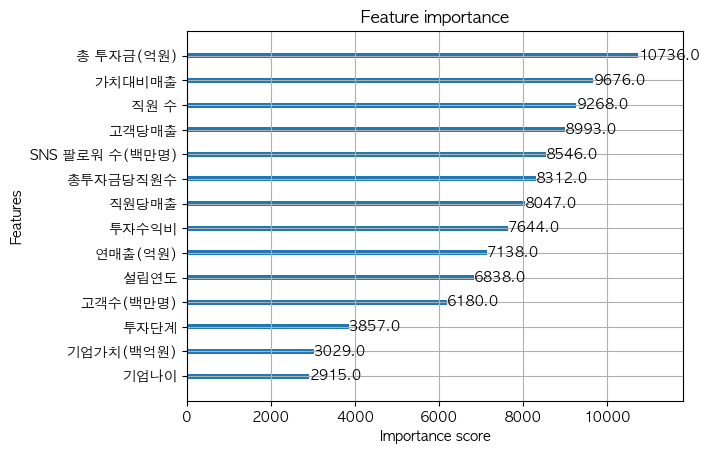

In [26]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
#맥에서 한글 안깨지게


rc('font', family='AppleGothic') # 애플 폰트 사용
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 안깨지게 설정

xgb.plot_importance(model)
plt.show()

## XGBoost 성공확률

In [30]:
submission.describe()

,성공확률
count,1755.000000
mean,0.494981
std,0.007452
min,0.456091
25%,0.495181
50%,0.495181
75%,0.495181
max,0.531470


In [41]:
train.shape

(3800, 11)

In [42]:
test.shape

(1755, 10)

In [25]:
import pandas as pd

# Fold별 MAE 값
lgbm_mae = [0.222366, 0.218781, 0.206600, 0.195580, 0.204213,
            0.220160, 0.216011, 0.213723, 0.209895, 0.206095]

nn_mae = [0.3112, 0.2944, 0.2916, 0.2793, 0.2506,
          0.2952, 0.2897, 0.2693, 0.2740, 0.2749]

rf_mae = [0.2413, 0.2360, 0.2353, 0.2253, 0.2323,
          0.2210, 0.2156, 0.2269, 0.2185, 0.2451]

xgb_mae = [0.2218, 0.2125, 0.2049, 0.1970, 0.1959,
           0.2126, 0.2073, 0.2082, 0.2053, 0.2022]

# Fold 번호 (LGBM, NN, XGB는 10개, RF는 15개)
fold_lgbm = list(range(1, 11))
fold_rf = list(range(1, 11))

# 통합 데이터프레임 생성
mae_df = pd.DataFrame({
    'Fold': fold_lgbm + fold_lgbm + fold_rf + fold_lgbm,
    'Model': ['MLP'] * 10 + ['LGBM'] * 10 + ['Random Forest'] * 10 + ['XGBoost'] * 10,
    'MAE': nn_mae + lgbm_mae + rf_mae + xgb_mae
})

# 확인
#rint(mae_df)

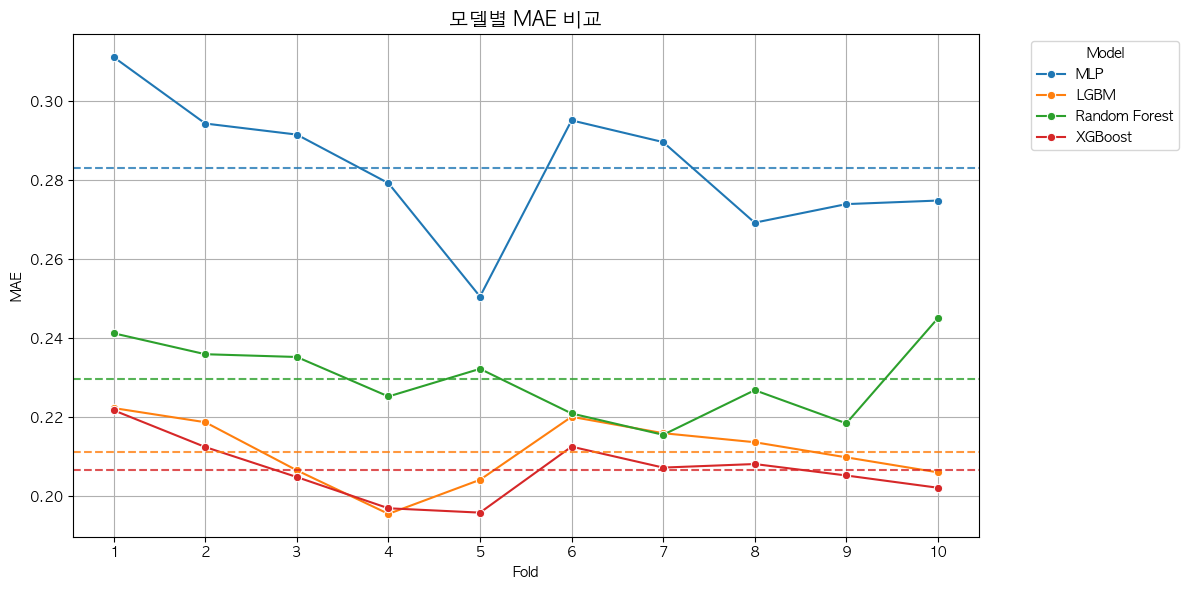

In [28]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import warnings
import pandas as pd

# 설정
warnings.simplefilter(action='ignore', category=FutureWarning)
rc('font', family='AppleGothic')  # 애플 폰트 사용
plt.rcParams['axes.unicode_minus'] = False

# 모델별 평균 MAE 계산
model_avg_df = mae_df.groupby('Model')['MAE'].mean().reset_index()
model_avg_df['Fold'] = '평균'  # 시각화에는 사용 안함. 참고용.

plt.figure(figsize=(12, 6))

# 팔레트 미리 받아오기 (모델 수에 맞게)
unique_models = mae_df['Model'].unique()
palette = sns.color_palette(n_colors=len(unique_models))

# 모델명-색상 매핑 딕셔너리 생성
model_color_dict = dict(zip(unique_models, palette))

# 라인플롯 그리기 (팔레트 지정)
sns.lineplot(data=mae_df, x='Fold', y='MAE', hue='Model', marker='o', palette=model_color_dict)

# 모델별 평균 MAE 수평선 추가 (색상 동일하게)
for _, row in model_avg_df.iterrows():
    plt.axhline(y=row['MAE'], linestyle='--', alpha=0.8, color=model_color_dict[row['Model']])

plt.title('모델별 MAE 비교', fontsize=14)
plt.xticks(mae_df['Fold'].unique())
plt.grid(True)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 선형모델

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# 데이터
X = train.drop(columns=['ID', '성공확률'])
y = train['성공확률']
X_test = test.drop(columns=['ID'])

# 결과 저장용
test_preds = np.zeros(len(X_test))
val_mae_list = []

# 교차검증 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 교차검증
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'\n📐 LinearRegression Fold {fold+1}')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_pred)
    val_mae_list.append(val_mae)
    print(f'📉 Fold {fold+1} MAE: {val_mae:.4f}')

    test_preds += model.predict(X_test) / kf.n_splits

print(f'\n✅ 평균 검증 MAE: {np.mean(val_mae_list):.4f} ± {np.std(val_mae_list):.4f}')

# 결과 저장
submission = pd.DataFrame({
    'ID': test['ID'],
    '성공확률': test_preds.clip(0, 1)
})
submission.to_csv('../../data/output/submission_linear.csv', index=False)


📐 LinearRegression Fold 1
📉 Fold 1 MAE: 0.2272

📐 LinearRegression Fold 2
📉 Fold 2 MAE: 0.2151

📐 LinearRegression Fold 3
📉 Fold 3 MAE: 0.2117

📐 LinearRegression Fold 4
📉 Fold 4 MAE: 0.2013

📐 LinearRegression Fold 5
📉 Fold 5 MAE: 0.1985

📐 LinearRegression Fold 6
📉 Fold 6 MAE: 0.2147

📐 LinearRegression Fold 7
📉 Fold 7 MAE: 0.2213

📐 LinearRegression Fold 8
📉 Fold 8 MAE: 0.2150

📐 LinearRegression Fold 9
📉 Fold 9 MAE: 0.2177

📐 LinearRegression Fold 10
📉 Fold 10 MAE: 0.2040

✅ 평균 검증 MAE: 0.2126 ± 0.0085


In [24]:
submission.describe()

,성공확률
count,1755.000000
mean,0.243626
std,0.428791
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000
